In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xg

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, mean_absolute_error, mean_squared_error, r2_score, roc_auc_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from imblearn.over_sampling import SMOTE

# Feature Importance & Explainability
import shap

import warnings
warnings.filterwarnings("ignore")

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
print("Libraries loaded. Ready to go!")

Libraries loaded. Ready to go!


In [46]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [47]:
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [48]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

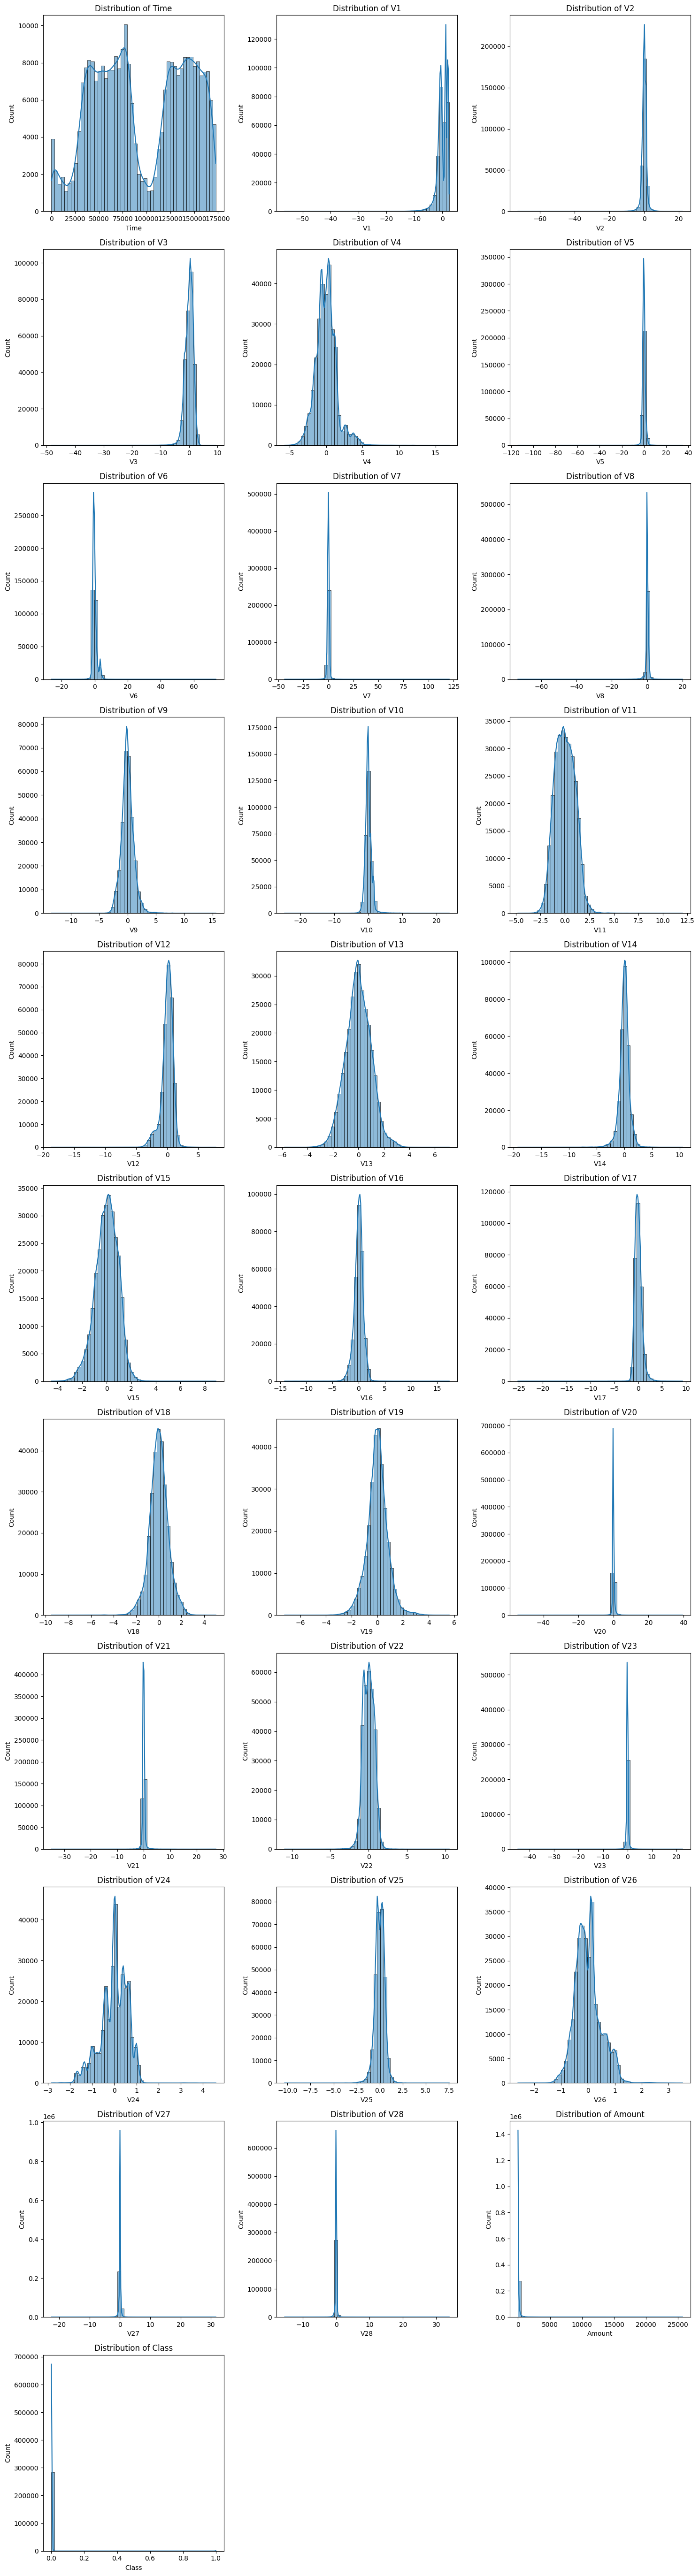

In [49]:
float_cols = [col for col in data.columns if data[col].dtype == "float64" or data[col].dtype == "int64"]

cols_per_row = 3
num_plots = len(float_cols)
rows = (num_plots // cols_per_row) + (num_plots % cols_per_row > 0)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 5 * rows))
axes = axes.flatten()

for idx, col in enumerate(float_cols):
    sns.histplot(data[col], bins=50, kde=True, ax=axes[idx])
    axes[idx].set_title(f"Distribution of {col}")

for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

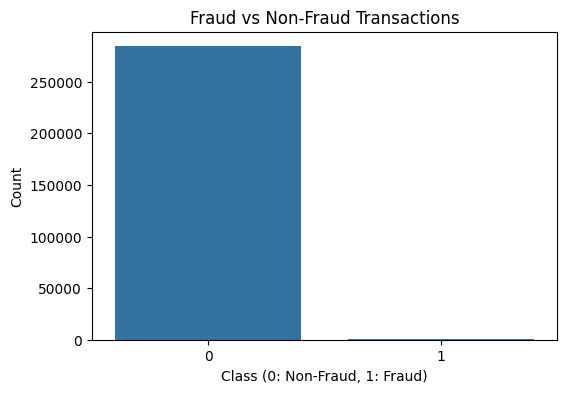

In [50]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, x='Class')
plt.title('Fraud vs Non-Fraud Transactions')
plt.xlabel('Class (0: Non-Fraud, 1: Fraud)')
plt.ylabel('Count')
plt.show()

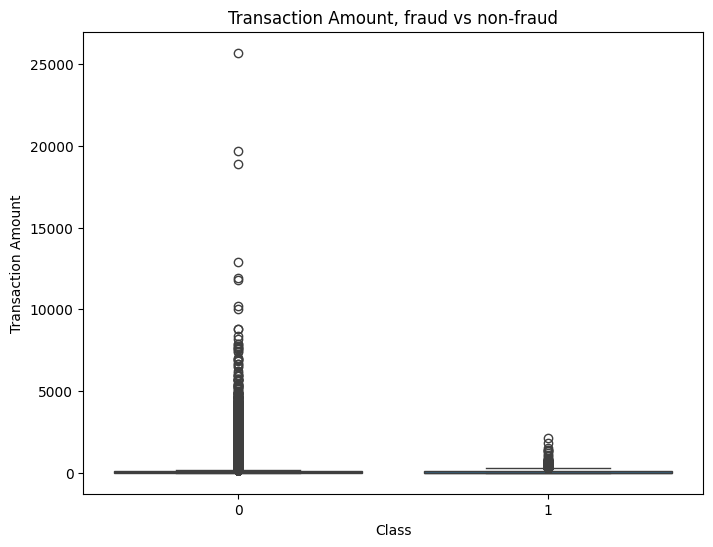

In [51]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='Class', y='Amount')
plt.title('Transaction Amount, fraud vs non-fraud')
plt.xlabel('Class')
plt.ylabel('Transaction Amount')
plt.show()

In [52]:
print(data.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [53]:
print(data.Class.value_counts())

Class
0    284315
1       492
Name: count, dtype: int64


In [54]:
y=data['Class']
print (y)

0         0
1         0
2         0
3         0
4         0
         ..
284802    0
284803    0
284804    0
284805    0
284806    0
Name: Class, Length: 284807, dtype: int64


In [55]:
data = data.dropna(subset=['Class'])
X = data.drop(columns=['Class'])
y = data['Class']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

In [56]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=SEED)
X_res, y_res = smote.fit_resample(X_train, y_train)
y_res.value_counts()

,count
Class,
0,227451
1,227451


In [57]:
model = xg.XGBClassifier()
model.fit(X_res, y_res)

predictions = model.predict(X_val)

In [58]:
val_accuracy = accuracy_score(y_val, predictions)
val_precision = precision_score(y_val, predictions)
val_recall = recall_score(y_val, predictions)
val_f1 = f1_score(y_val, predictions)
val_probs = model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_probs)

print("accuracy: ", val_accuracy)
print("precision: ", val_precision)
print("recall: ", val_recall)
print("f1: ", val_f1)
print("auc: ", val_auc)

accuracy:  0.9993504441557529
precision:  0.7904761904761904
recall:  0.8469387755102041
f1:  0.8177339901477833
auc:  0.9831145633548862


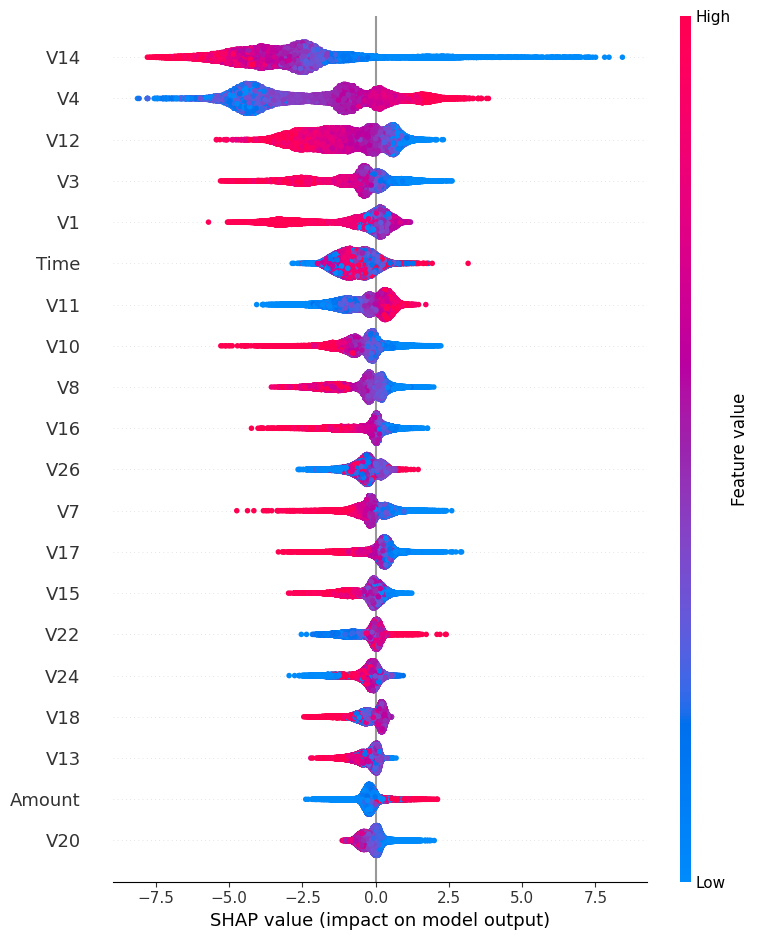

In [59]:
import plotly.io as pio
pio.renderers.default = "notebook"

explainer = shap.TreeExplainer(model)

shap_values = explainer.shap_values(X_val)

shap.summary_plot(shap_values, X_val)
shap.force_plot(explainer.expected_value, shap_values[0], X_val.iloc[0])

In [60]:
# Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from sklearn.metrics import confusion_matrix, roc_curve, auc
# Load Dataset
df = pd.read_csv("creditcard.csv")

# Check Class Distribution
print("Original class distribution:\n", df["Class"].value_counts())

# Normalize 'Amount' Feature
scaler = StandardScaler()
df["Amount"] = scaler.fit_transform(df[["Amount"]])

# Define Features & Target
X = df.drop(columns=["Class", "Time"])  # Drop 'Time' as it's not needed
y = df["Class"]
# Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Reshape Data for LSTM (3D: samples, timesteps, features)
X_resampled = np.reshape(X_resampled.values, (X_resampled.shape[0], 1, X_resampled.shape[1]))

# Split into Train & Test Sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Resampled class distribution:", np.bincount(y_resampled))


Original class distribution:
 Class
0    284315
1       492
Name: count, dtype: int64
Resampled class distribution: [284315 284315]


In [68]:
# ----------------- Build LSTM Model ---------------- #
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.3),
    LSTM(32),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train Model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 86s 6ms/step - accuracy: 0.9748 - loss: 0.0728 - val_accuracy: 0.9975 - val_loss: 0.0086
Epoch 2/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 81s 6ms/step - accuracy: 0.9964 - loss: 0.0120 - val_accuracy: 0.9986 - val_loss: 0.0055
Epoch 3/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 84s 6ms/step - accuracy: 0.9979 - loss: 0.0072 - val_accuracy: 0.9991 - val_loss: 0.0039
Epoch 4/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 82s 6ms/step - accuracy: 0.9986 - loss: 0.0052 - val_accuracy: 0.9992 - val_loss: 0.0033
Epoch 5/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 139s 6ms/step - accuracy: 0.9989 - loss: 0.0043 - val_accuracy: 0.9994 - val_loss: 0.0034
Epoch 6/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 80s 5ms/step - accuracy: 0.9988 - loss: 0.0048 - val_accuracy: 0.9994 - val_loss: 0.0031
Epoch 7/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - accuracy: 0.9991 - loss: 0.0038 - val_accuracy: 0.9993 - val_loss: 0.0029
Epoch 8/10
14216/14216 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - accuracy:

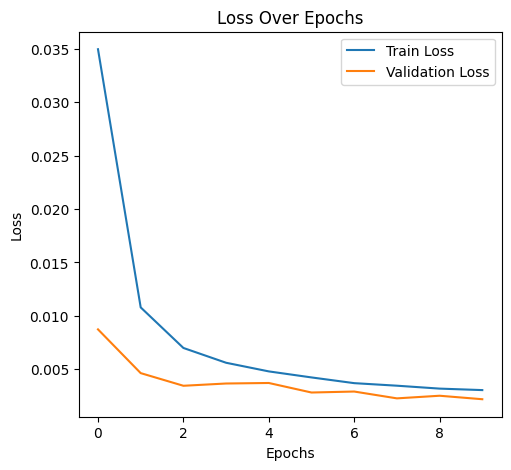

In [66]:
# ---------------- Visualization ---------------- #

# 1. Plot Training Loss & Accuracy
plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


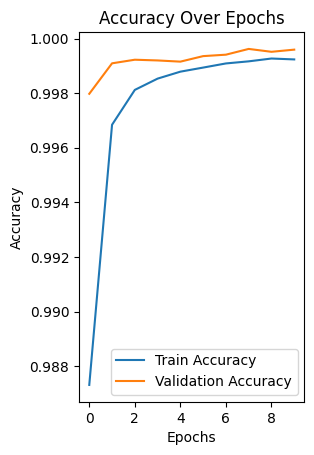

In [67]:
# 1. Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

3554/3554 ━━━━━━━━━━━━━━━━━━━━ 26s 7ms/step


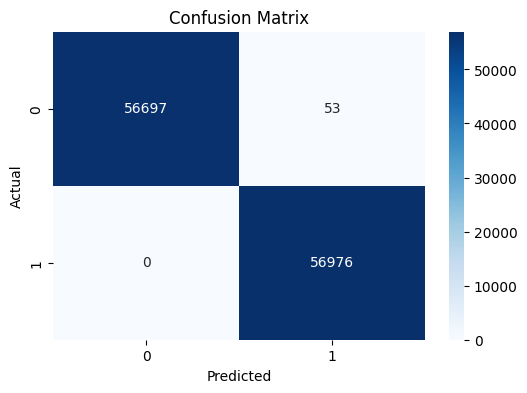

In [69]:
# 2. Confusion Matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

3554/3554 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


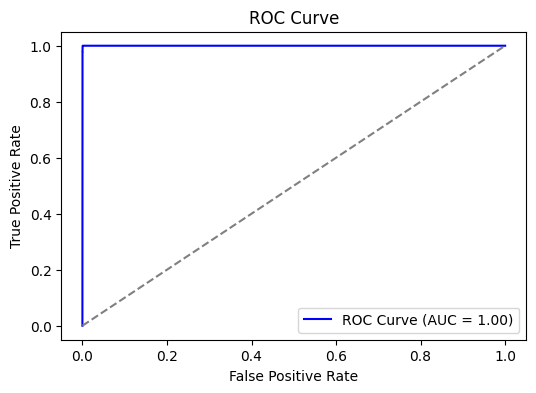

LSTM model training & evaluation completed successfully! 


In [70]:
# 3. ROC Curve
y_probs = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
print("LSTM model training & evaluation completed successfully! ")